# MPC EXPRESSION ANALYSIS NOTEBOOK  
Paper: Regulation of Tumor Initiation by the Mitochondrial Pyruvate Carrier   
Paper Authors: Claire L. Bensard and Dona R. Wisidigama, et. al.   

Analysis performed within the scope of this notebook by Jordan A. Berg and Alex J. Bott   
Description: The following notebook contains the code required to replicate specified plots and supplements

## Import Dependencies

In [1]:
import os
import re
import pandas as pd 
import xpressplot as xp
from scipy import stats
from math import sqrt
from statistics import mean, stdev
from sklearn import preprocessing
from statsmodels.stats.multitest import multipletests
import GEOparse
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#Some microarray data was also processed using Alt Analyze (http://www.altanalyze.org/)

#Set path to this directory for accessing and saving files
__path__  = os.getcwd() + '/'

ModuleNotFoundError: No module named 'xpressplot'

## Import Human Microarray Dataset GSE8671
The GEO-accessible data is not normalized. We therefore used Alt Analyze (http://www.altanalyze.org/) to RMA normalize probe signal.

In [2]:
#Get data
df_GSE8671 = xp.get_df(__path__ + 'data/GSE8671_rma_normalized.csv', delimiter=',') #RMA normalized with Alt Analyze
info_GSE8671 = xp.get_info(__path__ + "data/sample_info_gse8671.csv", delimiter=',')
df_GSE8671_c = xp.keep_labels(df_GSE8671, info_GSE8671, label_list=['Normal','Adenoma'])
df_GSE8671_clean = xp.clean_df(df_GSE8671_c)

#Collapse multi-mapping probes
df_GSE8671_collapsed = xp.probe_collapse(df_GSE8671_clean, __path__ + "data/GPL570.txt")
df_GSE8671_collapsed.to_csv(__path__ + "data/collapsed_GSE8671.csv",sep=',')

#Scale dataset
df_GSE8671_scaled, df_GSE8671_labeled = xp.prep_data(df_GSE8671_collapsed, info_GSE8671)

#sort by sample labels
info_GSE8671_sorted = info_GSE8671.copy()
info_GSE8671_sorted = info_GSE8671_sorted.loc[info_GSE8671_sorted[1].isin(['Adenoma', 'Normal'])]
info_GSE8671_sorted = info_GSE8671_sorted.sort_values([1], ascending=False)
info_GSE8671_sorted_list = info_GSE8671_sorted[0].tolist()
df_GSE8671_scaled_sorted = df_GSE8671_scaled[info_GSE8671_sorted_list]

#set palette
gse8671_colors = {'Adenoma': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
        'Normal': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)}

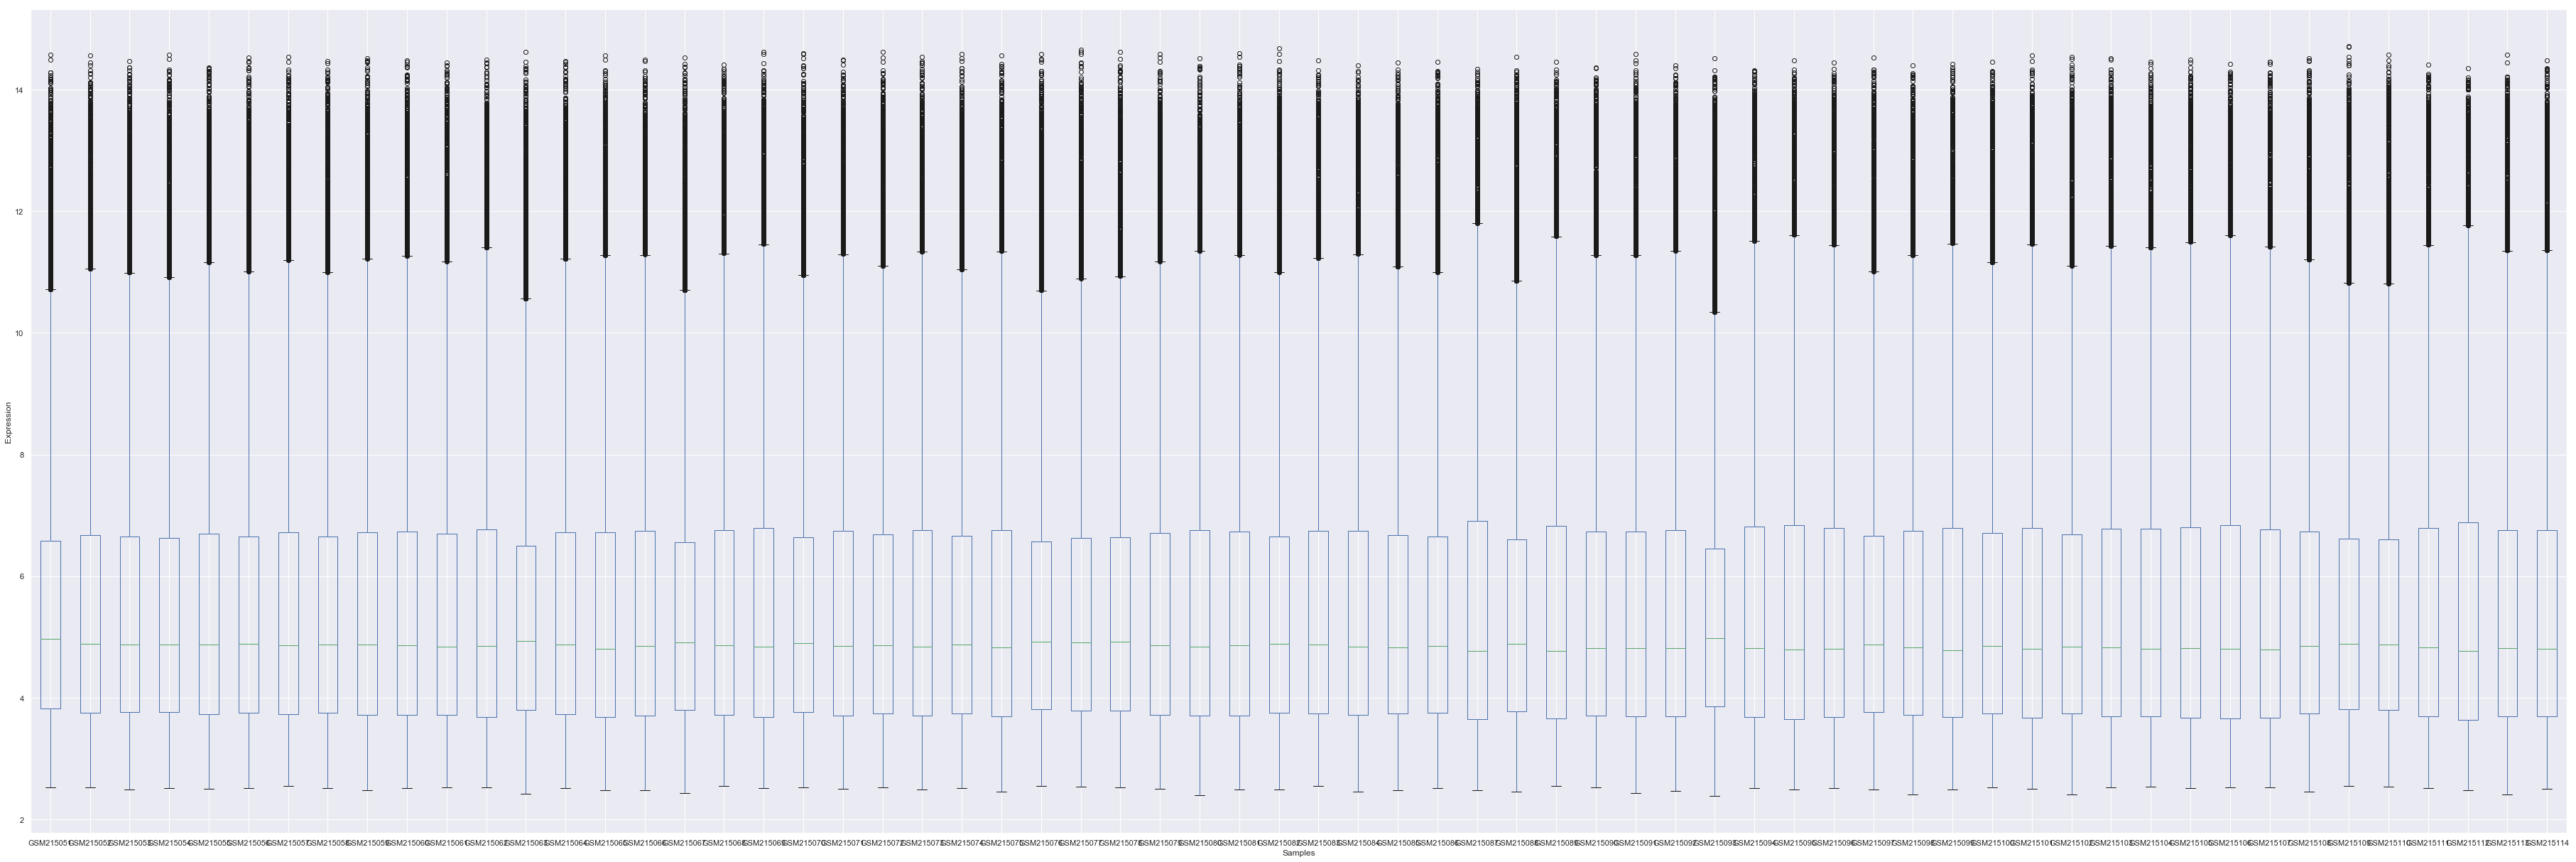

In [3]:
xp.check_samples(df_GSE8671_clean)

## Import Human Microarray Dataset GSE20916

In [4]:
def get_geo(
    geo_id,
    output_info=False, output_path="./"):

    # Get data
    gse = GEOparse.get_GEO(geo=str(geo_id).upper(), destdir=output_path) # Import GSE dataset

    data = gse.pivot_samples('VALUE')
    data = xp.clean_df(data)

    # Get metadata
    # Write data to output file
    if output_info != False:
        with open(str(geo_id).upper() + '.txt', 'w+') as f: # Save all information as text file for reference
            for gsm_name, gsm in gse.gsms.items():
                f.write(gsm_name + '\n')
                for key, value in gsm.metadata.items():
                    f.write(" - %s : %s" % (key, ", ".join(value)) + '\n')

    # Populate metadata with sample ids and names
    metadata = pd.DataFrame(columns=['gsm', 'title']) # Create dataframe
    gsm_list, title_list, data_processing_list = [], [], []
    for gsm_name, gsm in gse.gsms.items():
        for key, value in gsm.metadata.items():
            if key == 'title':
                title_list.append(''.join(value))
            if key == 'geo_accession':
                gsm_list.append(''.join(value))
            if key == 'data_processing':
                data_processing_list.append(''.join(value))

    metadata['gsm'], metadata['title'] = gsm_list, title_list
    metadata.columns = range(metadata.shape[1])

    # Output processing style
    print('Data processing summary:\n' + str(set(data_processing_list))) # To determine if all samples have undergone the sample data processing

    # Clean data
    del data.columns.name
    del data.index.name

    # Clean metadata
    metadata[1] = metadata[1].apply(lambda x: x[0:(re.search("\d", x).start()) - 1])

    return data, metadata

# Get data from GEO database 
#df_GSE20916, info_GSE20916 = get_geo('GSE20916')

#df_GSE20916.to_csv(__path__ + "data/GSE20916_normalized.csv", sep=',')
#info_GSE20916.to_csv(__path__ + "data/sample_info_gse20916.csv", sep=',', index=False)

In [5]:
#Get data
df_GSE20916 = pd.read_csv(__path__ + "data/GSE20916_normalized.csv", index_col=0)
info_GSE20916 = pd.read_csv(__path__ + "data/sample_info_gse20916.csv")
info_GSE20916.columns = [0,1]
info_GSE20916[1] = info_GSE20916[1].str.capitalize() #Make sample types look nice
info_GSE20916 = info_GSE20916.replace('Normal_colon', 'Normal')
df_GSE20916_c = xp.keep_labels(df_GSE20916, info_GSE20916, label_list=['Normal','Adenoma','Adenocarcinoma'])
df_GSE20916_clean = xp.clean_df(df_GSE20916_c)

#Collapse multi-mapping probes
df_GSE20916_collapsed = xp.probe_collapse(df_GSE20916_clean, __path__ + "data/GPL570.txt")
df_GSE20916_collapsed.to_csv(__path__ + "data/collapsed_GSE20916.txt",sep='\t')

#Scale sorted dataset
df_GSE20916_scaled, df_GSE20916_labeled = xp.prep_data(df_GSE20916_collapsed, info_GSE20916)

#sort by sample labels
info_GSE20916_sorted = info_GSE20916.copy()
info_GSE20916_sorted = info_GSE20916_sorted.loc[info_GSE20916_sorted[1].isin(['Adenoma', 'Adenocarcinoma','Normal'])]
info_GSE20916_sorted = info_GSE20916_sorted.sort_values([1], ascending=False)
info_GSE20916_sorted_list = info_GSE20916_sorted[0].tolist()
df_GSE20916_scaled_sorted = df_GSE20916_scaled[info_GSE20916_sorted_list]

#Drop Adenocarcinomas
df_GSE20916_collapsed_noac = xp.drop_label(df_GSE20916_collapsed, info_GSE20916, 'Adenocarcinoma')

gse20916_colors = {'Adenocarcinoma': (0.5725490196078431, 0.5843137254901961, 0.5686274509803921),
        'Adenoma': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
        'Normal': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)}

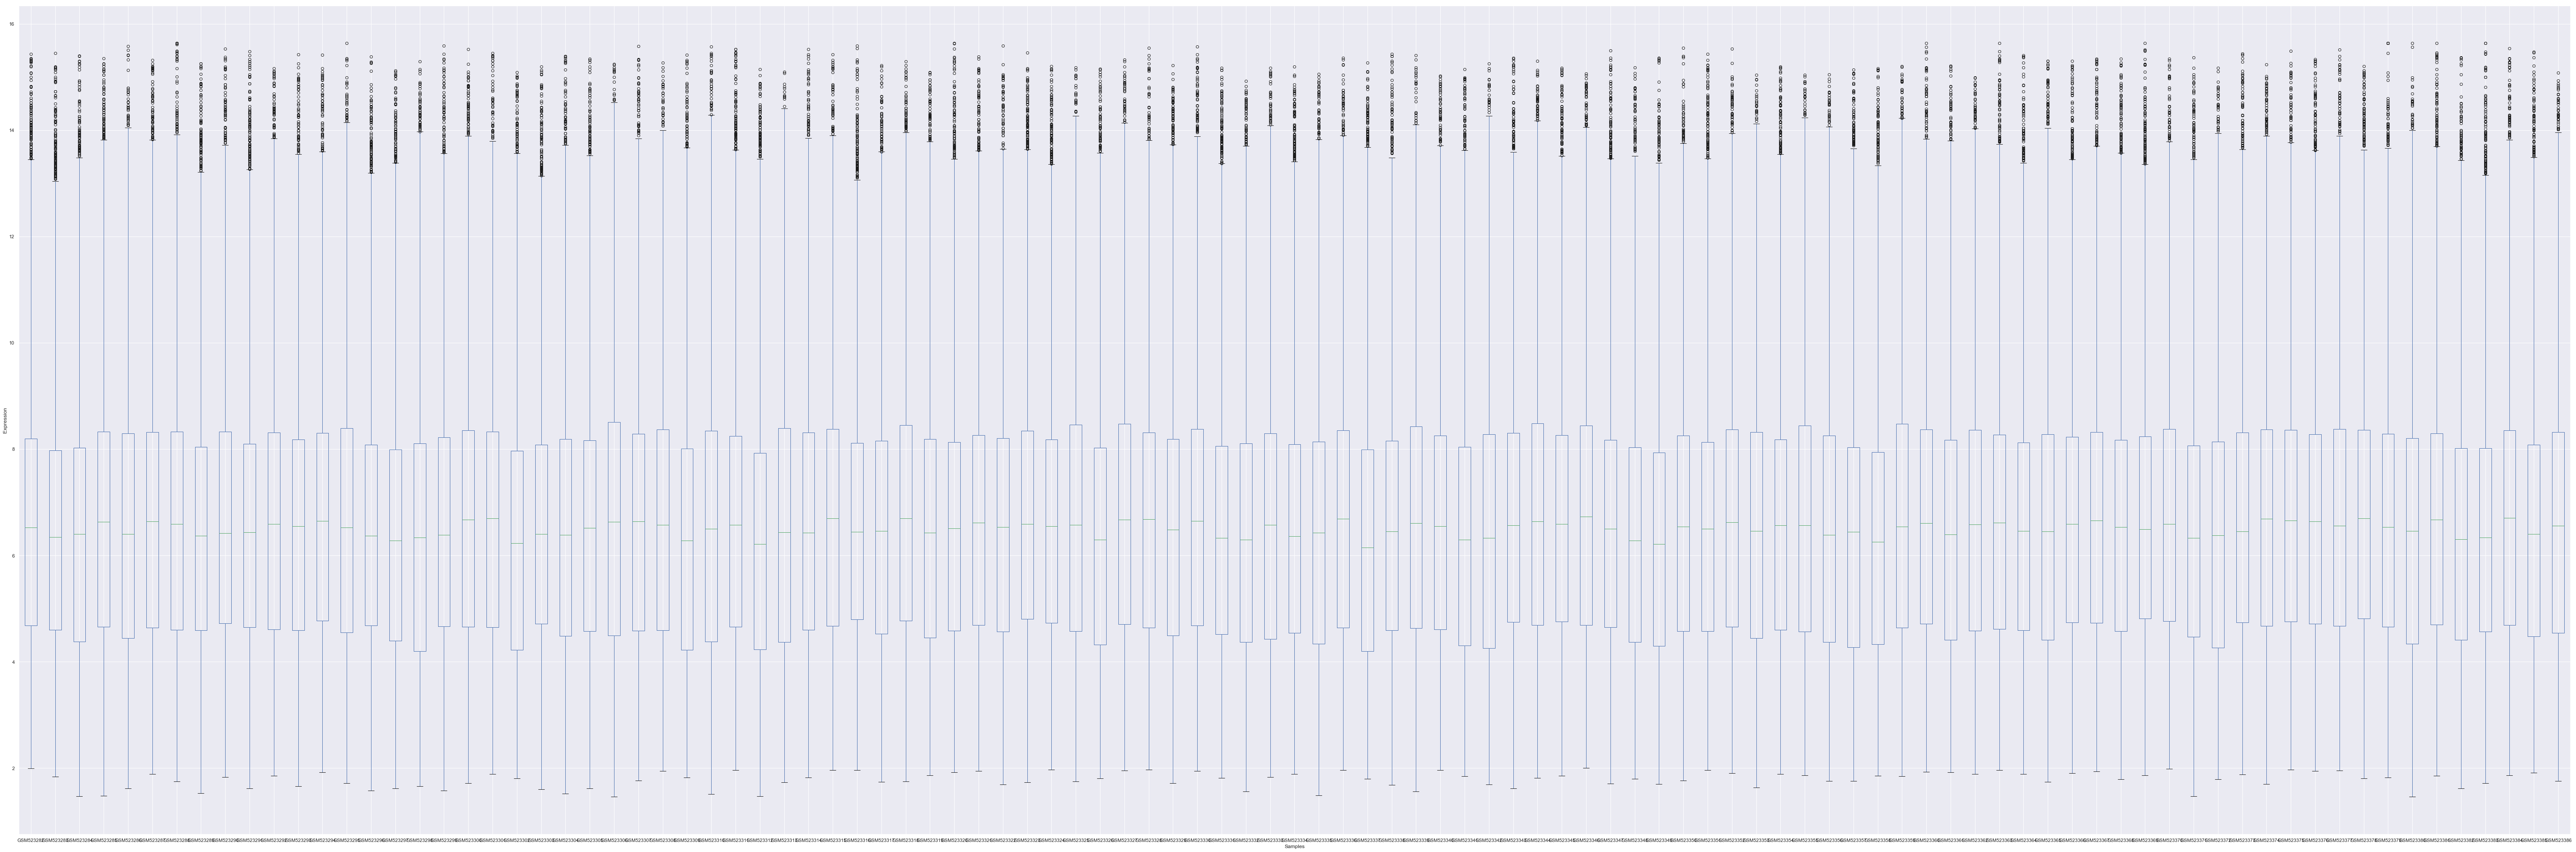

In [6]:
xp.check_samples(df_GSE20916_clean)

## Establish Gene Sets to Survey

In [9]:
test_genes = [
    'SPTLC1',
    'SPTLC2',
    'CERS6',
    'DEGS1',
    'DEGS2',
    'SGMS1',
    'SGMS2',
    'ME1', 
    'ME2', 
    'PC'
]

control_genes = [
    'CERS1', # doesn't seem to be expressed well in TCGA data
    'CERS2', # doesn't seem to be expressed well in TCGA data
    'CERS3', # doesn't seem to be expressed well in TCGA data
    'CERS4',
    'CERS5',
    'UGCG',
    'SPHK2',
    'SGPL1' # doesn't seem to be expressed well in TCGA data
]

## Summers 2020 gene list in Human Microarrays

<Figure size 432x288 with 0 Axes>

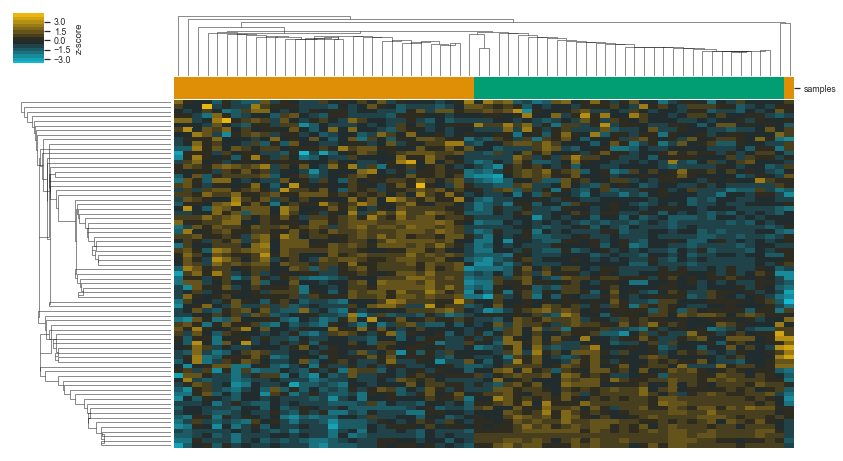

In [25]:
xp.heatmap(df_GSE8671_scaled_sorted, info_GSE8671, sample_palette=gse8671_colors, gene_list=test_genes+control_genes, 
            figsize=(14,8), save_fig=(__path__ + 'plots/GSE8671_summers2020_heatmap_colclustered.pdf'),
            row_cluster=True, col_cluster=True, yticklabels=False, xticklabels=False,
            cbar_kws={'label': 'z-score'}, linewidths=0)

<Figure size 432x288 with 0 Axes>

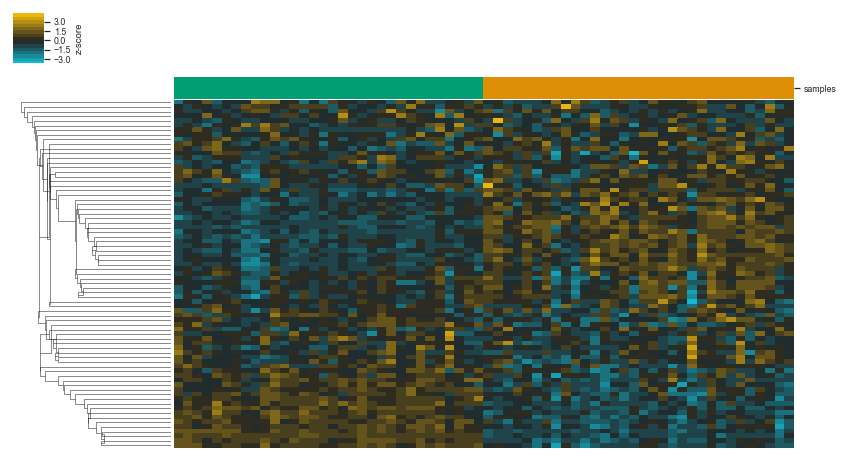

In [26]:
xp.heatmap(df_GSE8671_scaled_sorted, info_GSE8671, sample_palette=gse8671_colors, gene_list=test_genes+control_genes, 
            figsize=(14,8), save_fig=(__path__ + 'plots/GSE8671_summers2020_heatmap.pdf'),
            row_cluster=True, col_cluster=False, yticklabels=False, xticklabels=False,
            cbar_kws={'label': 'z-score'}, linewidths=0)

<Figure size 432x288 with 0 Axes>

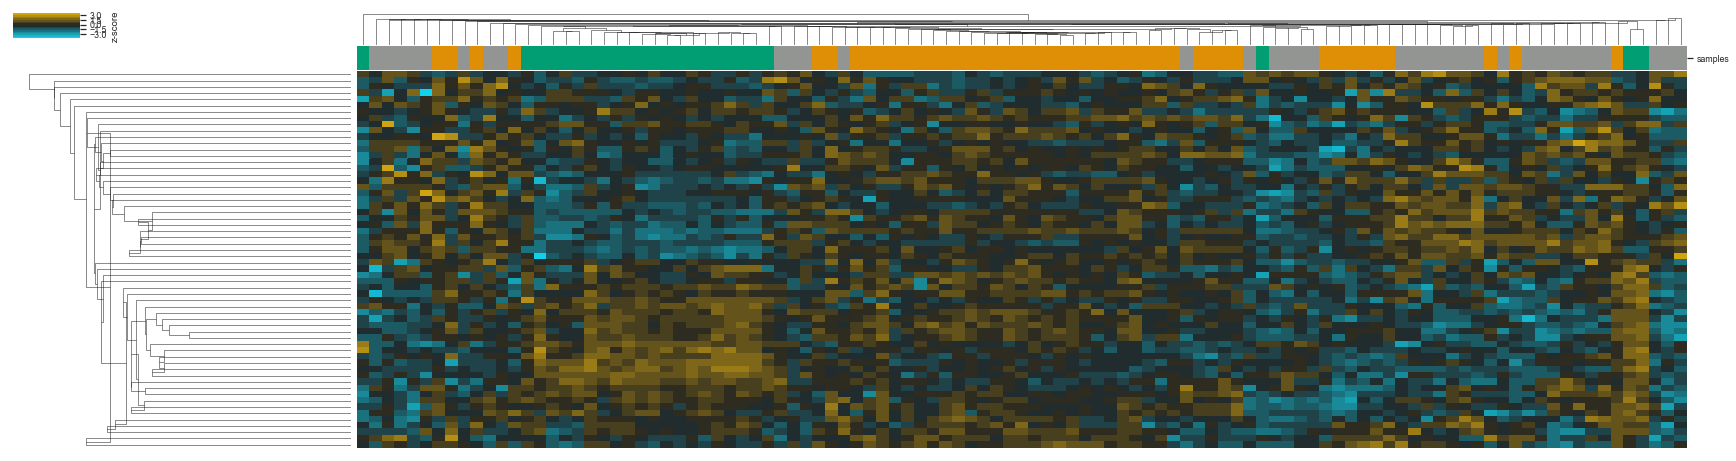

In [27]:
xp.heatmap(df_GSE20916_scaled_sorted, info_GSE20916, sample_palette=gse20916_colors, gene_list=test_genes+control_genes, 
            figsize=(30,8), save_fig=(__path__ + 'plots/GSE20916_summers2020_heatmap_colclustered.pdf'),
            row_cluster=True, col_cluster=True, yticklabels=False, xticklabels=False,
            cbar_kws={'label': 'z-score'}, linewidths=0)

<Figure size 432x288 with 0 Axes>

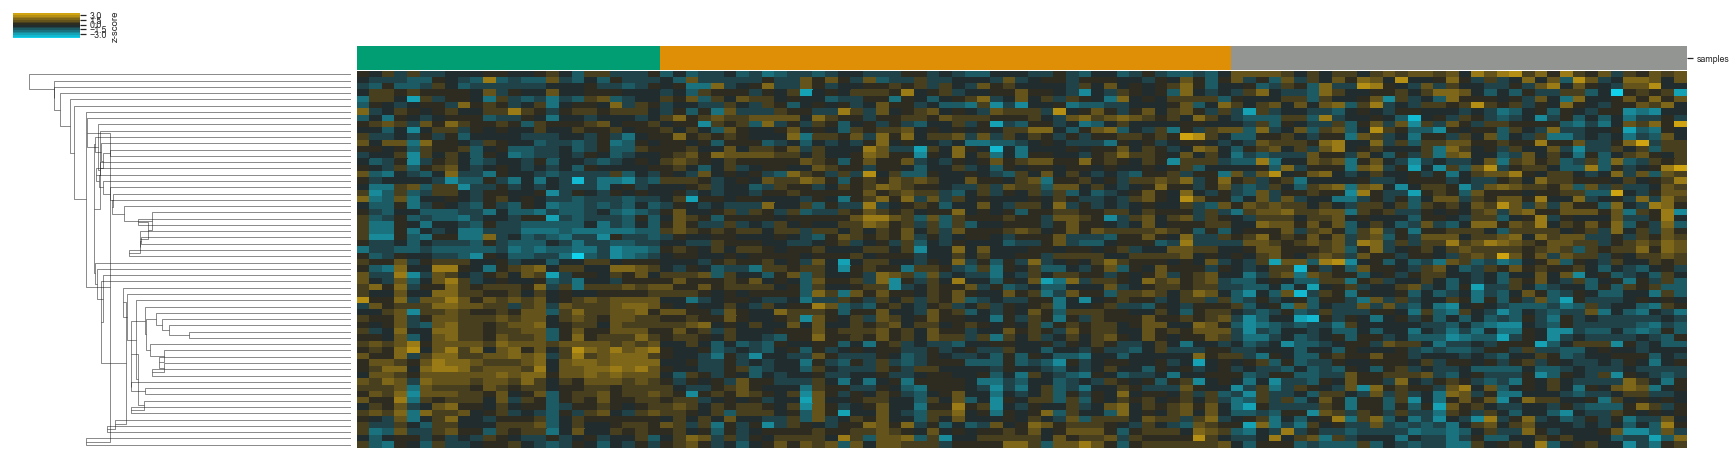

In [28]:
xp.heatmap(df_GSE20916_scaled_sorted, info_GSE20916, sample_palette=gse20916_colors, gene_list=test_genes+control_genes, 
            figsize=(30,8), save_fig=(__path__ + 'plots/GSE20916_summers2020_heatmap.pdf'),
            row_cluster=True, col_cluster=False, yticklabels=False, xticklabels=False,
            cbar_kws={'label': 'z-score'}, linewidths=0)